# Master's thesis code

**Sofia Morais - 152021001**

In [1]:
# Load the packages
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

## 1. DATA PREPARATION

### 1.1 Creating the new dataset

In [2]:
# Import the original dataset and save it
original = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/original/original.xlsx', header=1,index_col=0)

# Data transformation
original.index.name='Timestamp'
original = original.rename(columns={'google': 'btc_popularity'})
original = original.rename(columns={'n-transactions-per-block': 'Total-circulating-BTC'}) # correct the name of one variable
original = original.rename(columns={'n-transactions-per-block.1': 'n-transactions-per-block'}) # correct the name of one variable
original.drop(original.columns[-21:], axis=1, inplace=True) # Delete the columns that you will not use
original.head() # Check the first observations

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,n-transactions-total,btc_popularity,Open,n-payments-per-block,Total-circulating-BTC,cost-per-transaction-percent,fees-usd-per-transaction,n-unique-addresses,n-transactions-per-block,output-volume
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,183961799.0,43,963.4,0.0,1808.982832,0.757827,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,183961799.0,74,995.4,0.0,1808.982832,0.726644,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,183961799.0,69,1017.0,0.0,1808.982832,0.718670,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,183961799.0,79,1033.3,0.0,1830.788898,0.668387,0.307901,488315.4,276578.033333,1.797751e+06
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,184884526.0,100,1135.4,0.0,1830.788898,0.705463,0.307901,488315.4,276578.033333,1.797751e+06


In [3]:
# Import the confidence index dataset and save it
confidence = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/consumer confidence index.csv',index_col='TIME')

# Data transformation
confidence= confidence[confidence["LOCATION"].str.contains("OECD")==True]
confidence= confidence[confidence["LOCATION"].str.contains("OECDE")==False]
confidence= confidence.drop(['LOCATION','INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'], axis='columns')

# Delete the the rows that you will not use
for i in confidence.index:
    if i>'2021-06':
        confidence=confidence.drop(i)
    continue

# Check the last values to make sure that you the previous code worked
confidence.head()

,Value
TIME,
2017-01,100.5115
2017-02,100.5401
2017-03,100.6480
2017-04,100.7638
2017-05,100.8411


In [4]:
# Create an empty column
original['Confidence']=''

# Add the confidence index variable to the original dataset
for i in original.index.strftime('%Y-%m'):
    for j in confidence.index:
        if i==j:
            original['Confidence'][i]=confidence['Value'][j]
    continue
original['Confidence'].head(32) #check the values between the first 2 months to guarantee that the values were  copied

<ipython-input-4-2a55fca83ce8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Confidence'][i]=confidence['Value'][j]
C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Timestamp
2017-01-01    100.5115
2017-01-02    100.5115
2017-01-03    100.5115
2017-01-04    100.5115
2017-01-05    100.5115
2017-01-06    100.5115
2017-01-07    100.5115
2017-01-08    100.5115
2017-01-09    100.5115
2017-01-10    100.5115
2017-01-11    100.5115
2017-01-12    100.5115
2017-01-13    100.5115
2017-01-14    100.5115
2017-01-15    100.5115
2017-01-16    100.5115
2017-01-17    100.5115
2017-01-18    100.5115
2017-01-19    100.5115
2017-01-20    100.5115
2017-01-21    100.5115
2017-01-22    100.5115
2017-01-23    100.5115
2017-01-24    100.5115
2017-01-25    100.5115
2017-01-26    100.5115
2017-01-27    100.5115
2017-01-28    100.5115
2017-01-29    100.5115
2017-01-30    100.5115
2017-01-31    100.5115
2017-02-01    100.5401
Name: Confidence, dtype: object

In [5]:
# Import the variable gold save it
gold = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/gold.xlsx', header=4,index_col=1,sheet_name='Data')

# Create date and time with dataframe
data = pd.date_range('2014-01', periods = 104, freq ='M')

#Add to gold dataframe
gold.index=data

# Transform the data
gold.index=gold.index.strftime('%Y-%m')
gold.index.name='Timestamp'
gold= gold.drop(gold.columns[0], axis=1)
gold= gold.rename(columns={'Unnamed: 2': 'Price'})

# Delete the the rows that you will not use
for i in gold.index:
    if i<'2017-01' or i>'2021-06':
        gold=gold.drop(i)
    continue

gold.head()

,Price
Timestamp,
2017-01,1192.10
2017-02,1234.20
2017-03,1231.42
2017-04,1266.88
2017-05,1246.04


In [6]:
# Create an empty column
original['Gold']=''

# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in gold.index:
        if i==j:
            original['Gold'][i]=gold['Price'][j]
            
        continue
original['Gold'].head(32) #check the values between the first 2 months to guarantee that the values were copied

<ipython-input-6-312bbe7ac82a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Gold'][i]=gold['Price'][j]
C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Timestamp
2017-01-01    1192.1
2017-01-02    1192.1
2017-01-03    1192.1
2017-01-04    1192.1
2017-01-05    1192.1
2017-01-06    1192.1
2017-01-07    1192.1
2017-01-08    1192.1
2017-01-09    1192.1
2017-01-10    1192.1
2017-01-11    1192.1
2017-01-12    1192.1
2017-01-13    1192.1
2017-01-14    1192.1
2017-01-15    1192.1
2017-01-16    1192.1
2017-01-17    1192.1
2017-01-18    1192.1
2017-01-19    1192.1
2017-01-20    1192.1
2017-01-21    1192.1
2017-01-22    1192.1
2017-01-23    1192.1
2017-01-24    1192.1
2017-01-25    1192.1
2017-01-26    1192.1
2017-01-27    1192.1
2017-01-28    1192.1
2017-01-29    1192.1
2017-01-30    1192.1
2017-01-31    1192.1
2017-02-01    1234.2
Name: Gold, dtype: object

In [7]:
# Import the binary variable of bitcoin regulation related news and save it
news_reg = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/news_regulation.xlsx', header=0,index_col=0)
news_reg.head()

# Add this variable to the original dataset
original['News Regulation'] = news_reg['news_regulation']
original.head(10) #check the original dataset

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,n-payments-per-block,Total-circulating-BTC,cost-per-transaction-percent,fees-usd-per-transaction,n-unique-addresses,n-transactions-per-block,output-volume,Confidence,Gold,News Regulation
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,0.0,1808.982832,0.757827,0.288061,468609.6,272924.100000,1.693024e+06,100.5115,1192.1,0
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,0.0,1808.982832,0.726644,0.288061,468609.6,272924.100000,1.693024e+06,100.5115,1192.1,0
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,0.0,1808.982832,0.718670,0.288061,468609.6,272924.100000,1.693024e+06,100.5115,1192.1,0
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,0.0,1830.788898,0.668387,0.307901,488315.4,276578.033333,1.797751e+06,100.5115,1192.1,0
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,0.0,1830.788898,0.705463,0.307901,488315.4,276578.033333,1.797751e+06,100.5115,1192.1,0
2017-01-06,999.65,1.758021e+10,5.857834e+06,121958.044759,251.417225,3.176884e+11,1027.40,852.50,2.897298e+06,97743.656720,...,0.0,1830.788898,0.695898,0.307901,488315.4,276578.033333,1.797751e+06,100.5115,1192.1,0
2017-01-07,910.49,1.494351e+10,5.857834e+06,121958.044759,34.255985,3.176884e+11,910.49,806.70,2.796814e+06,98176.161409,...,0.0,1848.716302,0.736739,0.317517,512669.8,276702.666667,1.878899e+06,100.5115,1192.1,0
2017-01-08,910.49,1.494351e+10,5.857834e+06,83380.703646,24.342649,3.176884e+11,936.10,875.80,2.528855e+06,98176.161409,...,0.0,1848.716302,0.749817,0.317517,512669.8,276702.666667,1.878899e+06,100.5115,1192.1,0
2017-01-09,910.49,1.494351e+10,5.857834e+06,83380.703646,20.581883,3.368999e+11,910.50,870.90,3.031277e+06,98176.161409,...,0.0,1848.716302,0.775388,0.317517,512669.8,276702.666667,1.878899e+06,100.5115,1192.1,0


In [8]:
## Sentiment analysis using Google Trends (GT)
# Import the variables
GT = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/GT.csv', header=1,index_col=0)

# Data transformation
GT = GT.rename(columns={'bitcoin legal: (Worldwide)': 'legal'})
GT = GT.rename(columns={'bitcoin cryptocurrency: (Worldwide)': 'cryptocurrency'})
GT = GT.rename(columns={'bitcoin scam: (Worldwide)': 'scam'})

# Delete the the rows that you will not use
for i in GT.index:
    if i>'2021-06-13':
        GT=GT.drop(i)
    continue
GT.head(300)

,legal,cryptocurrency,scam
Week,,,
2017-01-01,1,2,1
2017-01-08,1,2,1
2017-01-15,1,1,1
2017-01-22,1,1,1
2017-01-29,1,1,1
...,...,...,...
2021-05-16,5,60,4
2021-05-23,3,37,4
2021-05-30,4,26,3


In [9]:
# Add the Bitcoin+legal keyword variable to the original dataset
original['GT_legal']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_legal'][i] =GT['legal'][GT.index[j]]
        continue
        
original['GT_legal'].head() #check the original dataset

<ipython-input-9-2af8b1b10c0f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['GT_legal'][i] =GT['legal'][GT.index[j]]
C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Timestamp
2017-01-01    1
2017-01-02    1
2017-01-03    1
2017-01-04    1
2017-01-05    1
Name: GT_legal, dtype: object

In [10]:
#Convert string <1 in legal variable to a float
for j in range(len(original['GT_legal'])):
    if original['GT_legal'][j]=='<1':
        original['GT_legal'][j]=0.5
    continue

<ipython-input-10-4aa6f749fe6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['GT_legal'][j]=0.5


In [11]:
# Add the Bitcoin+cryptocurrency keyword variable to the original dataset
original['GT_cryptocurrency']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_cryptocurrency'][i] =GT['cryptocurrency'][GT.index[j]]
        continue
original['GT_cryptocurrency'].head() #check the original dataset

<ipython-input-11-38b62c94f828>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['GT_cryptocurrency'][i] =GT['cryptocurrency'][GT.index[j]]


Timestamp
2017-01-01    2
2017-01-02    2
2017-01-03    2
2017-01-04    2
2017-01-05    2
Name: GT_cryptocurrency, dtype: object

In [12]:
original['GT_scam']=''

# Add the Bitcoin+scam keyword variable to the original dataset
original['GT_scam']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_scam'][i] =GT['scam'][GT.index[j]]
        continue

original['GT_scam'].head() #check the original dataset

<ipython-input-12-c829eaf86936>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['GT_scam'][i] =GT['scam'][GT.index[j]]


Timestamp
2017-01-01    1
2017-01-02    1
2017-01-03    1
2017-01-04    1
2017-01-05    1
Name: GT_scam, dtype: object

In [13]:
## S&P500 index
# Import the variable
SP500 = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/SP500.csv', header=0,index_col=0)
SP500 = SP500.rename(columns={'s1': 'Value'})
SP500= SP500.drop(['conf','status1'], axis='columns')
SP500.index = pd.to_datetime(SP500.index)
SP500.index=SP500.index.strftime('%Y-%m')
SP500.head()

,Value
date,
2017-01,2275.1160
2017-02,2329.9105
2017-03,2366.8222
2017-04,2359.3095
2017-05,2395.3459


In [14]:
original['SP500']=''
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in SP500.index:
        if i==j:
            original['SP500'][i]=SP500['Value'][j]
            
        continue
original['SP500'].head(32) #check the values between the first 2 months to guarantee that the values were copied

<ipython-input-14-d47781a0b7d0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['SP500'][i]=SP500['Value'][j]
C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Timestamp
2017-01-01     2275.116
2017-01-02     2275.116
2017-01-03     2275.116
2017-01-04     2275.116
2017-01-05     2275.116
2017-01-06     2275.116
2017-01-07     2275.116
2017-01-08     2275.116
2017-01-09     2275.116
2017-01-10     2275.116
2017-01-11     2275.116
2017-01-12     2275.116
2017-01-13     2275.116
2017-01-14     2275.116
2017-01-15     2275.116
2017-01-16     2275.116
2017-01-17     2275.116
2017-01-18     2275.116
2017-01-19     2275.116
2017-01-20     2275.116
2017-01-21     2275.116
2017-01-22     2275.116
2017-01-23     2275.116
2017-01-24     2275.116
2017-01-25     2275.116
2017-01-26     2275.116
2017-01-27     2275.116
2017-01-28     2275.116
2017-01-29     2275.116
2017-01-30     2275.116
2017-01-31     2275.116
2017-02-01    2329.9105
Name: SP500, dtype: object

In [15]:
# Import the variable
oil = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/oil price.xlsx', sheet_name='Data',header=4,index_col=1)
oil=oil.drop(['Unnamed: 0'],axis='columns')
oil = oil.rename(columns={'Unnamed: 2': 'Price'})

# Delete the the rows that you will not use
for i in oil.index:
    if i<'2017' or i>'2021':
        oil=oil.drop(i)
    continue
oil.head()

,Price
2017,52.51
2018,69.78
2019,64.04
2020,41.47
2021,69.72


In [16]:
original['Oil']=''
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y'):
    for j in oil.index:
        if i==j:
            original['Oil'][i]=oil['Price'][j]
            
        continue
original['Oil'].head(366) #check the values between the first 2 years to guarantee that the values were copied

<ipython-input-16-4d234c043768>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Oil'][i]=oil['Price'][j]
C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Timestamp
2017-01-01    52.51
2017-01-02    52.51
2017-01-03    52.51
2017-01-04    52.51
2017-01-05    52.51
              ...  
2017-12-28    52.51
2017-12-29    52.51
2017-12-30    52.51
2017-12-31    52.51
2018-01-01    69.78
Name: Oil, Length: 366, dtype: object

In [17]:
theft = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/theft-2016-2020.xlsx', sheet_name='Data',header=4,index_col=1)
# Data Transformation of theft dataset
theft=theft.drop(['Unnamed: 0'],axis='columns')
theft = theft.rename(columns={'Unnamed: 2': 'Lost'})
theft.index = pd.to_datetime(theft.index,yearfirst=True, format= "%Y")
theft.index.name='Date'
theft.index=theft.index.strftime('%Y')
print(theft.head())

theft1 = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/theft-2020-2022.xlsx', sheet_name='Data',header=4,index_col=1)
# Data Transformation of theft1 dataset
theft1=theft1.drop(['Unnamed: 0','Recovered'],axis='columns')
theft1.index = pd.to_datetime(theft1.index)
theft1.index.name='Date'
theft1.index=theft1.index.strftime('%Y-%m')

# Delete the the rows that you will not use
for i in theft1.index:
    if i<='2020-12' or i>'2021-06':
        theft1=theft1.drop(i)
    continue
theft1.head()

       Lost
Date       
2016  152.0
2017  266.0
2018  950.0
2019  370.7
2020  513.0


,Lost
Date,
2021-01,6.21
2021-02,62.35
2021-03,87.52
2021-04,123.28
2021-05,287.47


In [18]:
# Create an empty variable in the original dataset
original['Theft']=''

# Copy this variable to the original dataframe
for i in original.index.strftime('%Y'):
    for j in theft.index:
        if i==j:
            original['Theft'][i]=theft['Lost'][j]
        continue
original['Theft'].head(366) #check the values between the first 2 years to guarantee that the values were copied

<ipython-input-18-a6ed4ab8ce09>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Theft'][i]=theft['Lost'][j]
C:\Users\sofia\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Timestamp
2017-01-01    266.0
2017-01-02    266.0
2017-01-03    266.0
2017-01-04    266.0
2017-01-05    266.0
              ...  
2017-12-28    266.0
2017-12-29    266.0
2017-12-30    266.0
2017-12-31    266.0
2018-01-01    950.0
Name: Theft, Length: 366, dtype: object

In [19]:
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in theft1.index:
        if i==j:
            original['Theft'][i]=theft1['Lost'][j]
        continue

#check the values between the first 2 months of 2021 to guarantee that the values were copied
for i in original.index.strftime('%Y-%m-%d'):
    if i>'2021-01-01' and i<='2021-02-01':
        print(original['Theft'][i])

<ipython-input-19-7fe483cf85c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Theft'][i]=theft1['Lost'][j]


Timestamp
2021-01-02    6.21
Name: Theft, dtype: object
Timestamp
2021-01-03    6.21
Name: Theft, dtype: object
Timestamp
2021-01-04    6.21
Name: Theft, dtype: object
Timestamp
2021-01-05    6.21
Name: Theft, dtype: object
Timestamp
2021-01-06    6.21
Name: Theft, dtype: object
Timestamp
2021-01-07    6.21
Name: Theft, dtype: object
Timestamp
2021-01-08    6.21
Name: Theft, dtype: object
Timestamp
2021-01-09    6.21
Name: Theft, dtype: object
Timestamp
2021-01-10    6.21
Name: Theft, dtype: object
Timestamp
2021-01-11    6.21
Name: Theft, dtype: object
Timestamp
2021-01-12    6.21
Name: Theft, dtype: object
Timestamp
2021-01-13    6.21
Name: Theft, dtype: object
Timestamp
2021-01-14    6.21
Name: Theft, dtype: object
Timestamp
2021-01-15    6.21
Name: Theft, dtype: object
Timestamp
2021-01-16    6.21
Name: Theft, dtype: object
Timestamp
2021-01-17    6.21
Name: Theft, dtype: object
Timestamp
2021-01-18    6.21
Name: Theft, dtype: object
Timestamp
2021-01-19    6.21
Name: Theft, dtype:

In [20]:
# Export the final dataset to Excel
original.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx')

### 1.2 Cleaning the data

In [73]:
# Reading the final dataset
final = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)
final.head() # check the pre-cleaned dataset

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,output-volume,Confidence,Gold,News Regulation,GT_legal,GT_cryptocurrency,GT_scam,SP500,Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,266.0
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,266.0
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,266.0
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,1.797751e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,266.0
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,1.797751e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,266.0


In [22]:
# Check if there is any missing value in the dataset
check_nan = final.isnull().values.any()
print(check_nan)

False


## 2. DATA EXPLORATION

*Now we are able to extract the main information from the final dataset*

### 2.1 Descriptive Statistics

In [23]:
final.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
market-price,1615.0,1.130001e+04,1.279853e+04,7.809200e+02,4.394070e+03,7.941460e+03,1.061149e+04,6.355444e+04
market-cap,1615.0,1.507716e+11,1.512407e+11,6.203007e+07,6.682616e+10,1.295255e+11,1.768332e+11,1.066163e+12
trade-volume,1615.0,3.747449e+08,4.580419e+08,4.765228e+06,8.960945e+07,2.157341e+08,5.139935e+08,4.956850e+09
transaction-fees-usd,1615.0,1.378138e+06,2.378999e+06,4.154115e+04,1.765076e+05,3.943438e+05,1.248912e+06,2.128565e+07
avg-confirmation-time,1615.0,1.201923e+02,3.341697e+02,5.521109e+00,1.816567e+01,3.896196e+01,1.016503e+02,7.961568e+03
difficulty,1615.0,9.172798e+12,7.115506e+12,4.758959e+10,2.741272e+12,6.727225e+12,1.554675e+13,2.335553e+13
High,1615.0,1.165746e+04,1.319941e+04,8.264000e+02,4.653900e+03,8.158800e+03,1.089405e+04,6.437400e+04
Low,1615.0,1.093589e+04,1.238778e+04,7.395000e+02,4.318580e+03,7.714500e+03,1.025045e+04,6.234800e+04
hash-rate,1615.0,6.665707e+07,5.141388e+07,2.147763e+06,2.044515e+07,5.010417e+07,1.117642e+08,1.749392e+08
block-size,1615.0,2.151992e+05,7.085936e+04,9.729388e+04,1.566525e+05,2.093699e+05,2.739406e+05,3.458966e+05


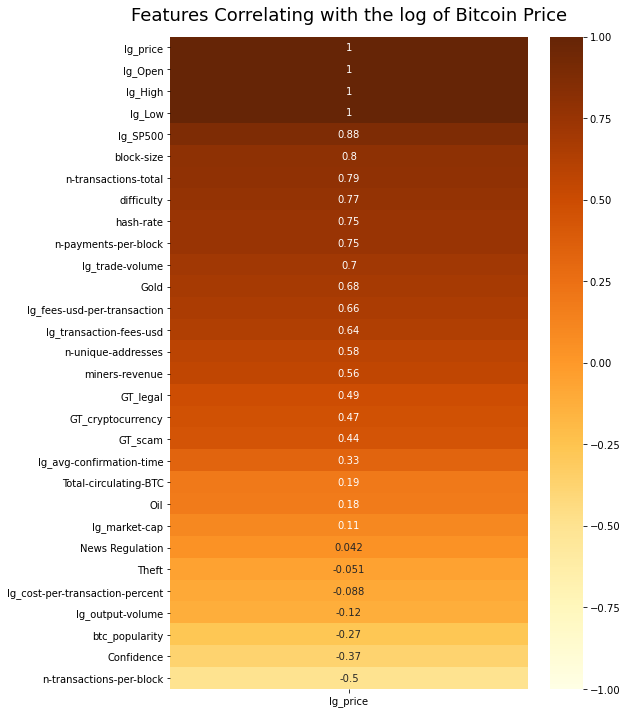

In [71]:
model.corr()[['lg_price']].sort_values(by='lg_price', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(model.corr()[['lg_price']].sort_values(by='lg_price', ascending=False), vmin=-1, vmax=1, annot=True, cmap="YlOrBr")
heatmap.set_title('Features Correlating with the log of Bitcoin Price', fontdict={'fontsize':18}, pad=16);

*Most important conclusions obtained from this correlations heatmap:*

*1. The log of SP500 presents the highest correlation in the log of BTC price and it is not a transactions-based variable.*

*2. Although "legal" is not the most frequent Google Trend keyword, comparing to the other two, it is the most correlated one with BTC price. Note that this keyword represents a positive sentiment regarding Bitcoin.*

*3. An interesting fact is that when consumers' confidence index increases, which reflects a positive sentiment about the general economic situation, unemployment and capability of savings, the log of BTC price decreases. In this case, will they demand substitute assets of BTC?*

*4. There are transaction-based variables that are not highly correlated with the log of BTC price, as it had been expected, namely the log of market capitalisation.*

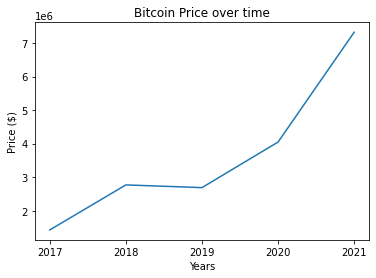

In [24]:
# PLot the market price over time
year_df=final.groupby(final.index.year)['market-price'].sum()
new_list = range(math.floor(min(year_df.index)), math.ceil(max(year_df.index))+1)
plt.xticks(new_list)
plt.plot(year_df.index,year_df)
plt.title('Bitcoin Price over time')
plt.ylabel('Price ($)')
plt.xlabel('Years')
plt.show()

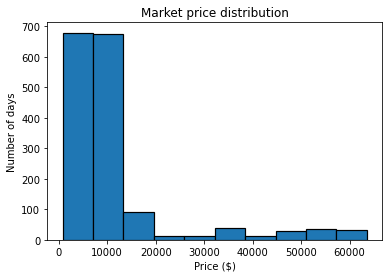

In [25]:
plt.hist(final['market-price'],edgecolor='black', linewidth=1.2)
plt.title('Market price distribution')
plt.ylabel('Number of days')
plt.xlabel('Price ($)')
plt.show()

*As we can see, the BTC price is clearly skewed to the right. This means that we should apply log transformation to the variable.*

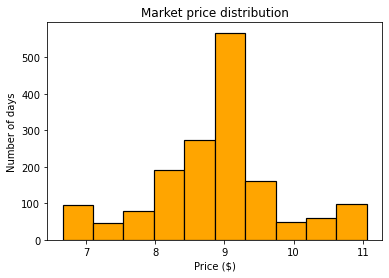

In [26]:
# Creating a new dataframe to model
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)

# Applying log transformation into price-variables
model['market-price']=np.log(model['market-price'])
model['market-cap']=np.log(model['market-cap'])
model['High']=np.log(model['High'])
model['Low']=np.log(model['Low'])
model['Open']=np.log(model['Open'])
model['cost-per-transaction-percent']=np.log(model['cost-per-transaction-percent'])
model['fees-usd-per-transaction']=np.log(model['fees-usd-per-transaction'])
model['transaction-fees-usd']=np.log(model['transaction-fees-usd'])

# Rename the log variables
model = model.rename(columns={'market-price': 'lg_price'})
model = model.rename(columns={'market-cap': 'lg_market-cap'})
model = model.rename(columns={'High': 'lg_High'})
model = model.rename(columns={'cost-per-transaction-percent': 'lg_cost-per-transaction-percent'})
model = model.rename(columns={'Open': 'lg_Open'})
model = model.rename(columns={'Low': 'lg_Low'})
model = model.rename(columns={'fees-usd-per-transaction': 'lg_fees-usd-per-transaction'})
model = model.rename(columns={'transaction-fees-usd': 'lg_transaction-fees-usd'})

# Visualize the new transformation
two=plt.hist(model['lg_price'],edgecolor='black', linewidth=1.2, color='orange')
plt.title('Market price distribution')
plt.ylabel('Number of days')
plt.xlabel('Price ($)')
plt.show()

*Now we have a Normal Distribution as intended.*

*Next, we are going to investigate the same issue for some explanatory variables where we may need to apply the same solution.*

Text(0.5, 1.0, '6')

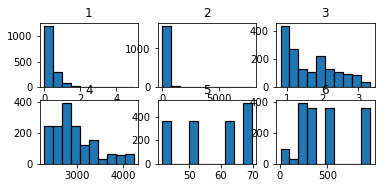

In [27]:

#Plot 1 - Trade Volume
plt.subplot(3,3,1)
plt.hist(model['trade-volume'],edgecolor='black', linewidth=1.2)
plt.title('1')

#Plot 2 - Average Confirmation Time
plt.subplot(3,3,2)
plt.hist(model['avg-confirmation-time'],edgecolor='black', linewidth=1.2)
plt.title('2')

#Plot 3 - Output Volume
plt.subplot(3,3,3)
plt.hist(model['output-volume'],edgecolor='black', linewidth=1.2)
plt.title('3')

#Plot 4 - SP500
plt.subplot(3,3,4)
plt.hist(model['SP500'],edgecolor='black', linewidth=1.2)
plt.title('4')

#Plot 5 - Oil
plt.subplot(3,3,5)
plt.hist(model['Oil'],edgecolor='black', linewidth=1.2)
plt.title('5')

#Plot 6 - Theft
plt.subplot(3,3,6)
plt.hist(model['Theft'],edgecolor='black', linewidth=1.2)
plt.title('6')

*The first four plots are shewed to the right, especially, the first three ones. Thefore,it seems reasonable to use log transformation for all these four plots.*

In [28]:
# Log transformation
model['trade-volume']=np.log(model['trade-volume'])
model['avg-confirmation-time']=np.log(model['avg-confirmation-time'])
model['output-volume']=np.log(model['output-volume'])
model['SP500']=np.log(model['SP500'])

# Rename the variables
model = model.rename(columns={'trade-volume': 'lg_trade-volume'})
model = model.rename(columns={'avg-confirmation-time': 'lg_avg-confirmation-time'})
model = model.rename(columns={'output-volume': 'lg_output-volume'})
model = model.rename(columns={'SP500': 'lg_SP500'})

In [72]:
# Export the dataset to Excelthat will be used to modelling
model.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx')

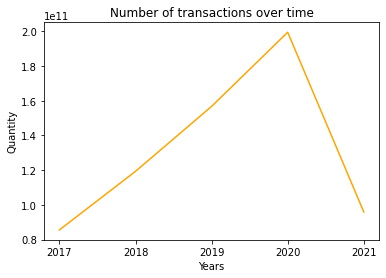

In [30]:
# PLot number of transactions of BTC over time
year_df=final.groupby(final.index.year)['n-transactions-total'].sum()
new_list = range(math.floor(min(year_df.index)), math.ceil(max(year_df.index))+1)
plt.xticks(new_list)
plt.plot(year_df.index,year_df, color='orange')
plt.title('Number of transactions over time')
plt.ylabel('Quantity')
plt.xlabel('Years')
plt.show()

Text(0.5, 1.0, 'scam')

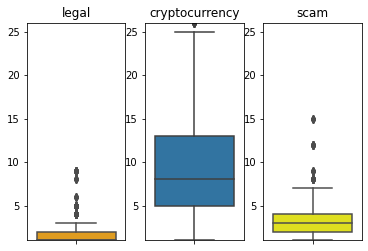

In [69]:
# Finding which keyword associated with Bitcoin that is more frequent in Google Trends
# Bitcoin+legal - POSITIVE SENTIMENT
plt.subplot(1,3,1)
sns.boxplot(y='GT_legal',data=model,color='orange')
plt.ylim(1, 26)
plt.ylabel('')
plt.title('legal')

# Bitcoin+cryptocurrency - NEUTRAL SENTIMENT
plt.subplot(1,3,2)
sns.boxplot(y='GT_cryptocurrency',data=model)
plt.ylim(1, 26)
plt.ylabel('')
plt.title('cryptocurrency')

# Bitcoin+scam - NEGATIVE SENTIMENT
plt.subplot(1,3,3)
sns.boxplot(y='GT_scam',data=model, color='yellow')
plt.ylim(1, 26)
plt.ylabel('')
plt.title('scam')

*It seems that, on average, the neutral sentiment regarding Bitcoin is the more usual, comparing to postive sentiment and negative sentiment expressed through Google searches.*

## 3. MODELLING

In [74]:
# Reading the model dataset
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)